In [1]:
import pandas as pd, numpy as np, os, re
from bs4 import BeautifulSoup
from glob import iglob
import codecs
pd.set_option('display.max_columns', 40)

In [2]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, LeaveOneOut

from sklearn.model_selection import cross_val_score


In [3]:
from matplotlib import pyplot as plt

In [17]:
df_al = pd.read_csv('df_al.csv', sep=';')

In [18]:
df_al = df_al[df_al.Mileage != 'Not provided']

In [24]:
df_al.price = df_al.price.apply(lambda x: x.replace('$', '').replace(',', ''))
df_al.msrp_price = df_al.msrp_price.apply(lambda x: x.replace('$', '').replace(',', '') if pd.notnull(x) else x)

df_al.original_price = df_al.original_price.apply(lambda x: x.replace('$', '').replace(',', '') if pd.notnull(x) else x)
df_al.Mileage = df_al.Mileage.apply(lambda x: float(x.replace(',', '').strip()) if pd.notnull(x) else x)

In [25]:
df_al.seller_rating = df_al.seller_rating.astype('float')
df_al.car_rate = df_al.car_rate.astype('float')

df_al.n_photos = df_al.n_photos.apply(lambda x: int(x) if pd.notnull(x) else x)
df_al.seller_count_rating = df_al.seller_count_rating.astype('int')


In [26]:
df_al.consumers_review = df_al.consumers_review.apply(lambda x: int(x.replace('reviews', '').strip()) if pd.notnull(x) else x)

In [27]:
df_al.drop('id', inplace=True, axis=1)

df_al.fillna(-1, inplace=True)

In [28]:
df_al.price = df_al.price.astype('float')
df_al.msrp_price = df_al.msrp_price.astype('float')
df_al.original_price = df_al.original_price.astype('float')

In [29]:
df_al.drop(columns=['VIN', 'Stock', 'Interior Color'],inplace=True)

In [82]:
df_al_2 = df_al.drop(['Exterior Color'], axis=1)

In [83]:
df_al_2

,price,msrp_price,original_price,good_offer,seller_rating,seller_count_rating,car_rate,consumers_review,n_photos,City MPG,Drivetrain,Engine,Fuel Type,Highway MPG,Mileage,Transmission
0,23665.0,23665.0,NaN,NaN,4.6,122,4.3,129.0,15.0,30.0,FWD,1.4L I4 16V GDI DOHC Turbo,Gasoline,40.0,10.0,8-Speed Automatic
1,28994.0,NaN,NaN,Good Deal,4.8,1086,4.8,36.0,41.0,NaN,RWD,Twin Turbo Premium Unleaded V-6 3.0 L/183,Gasoline,NaN,37224.0,7-Speed Automatic w/OD
2,31000.0,34515.0,NaN,NaN,4.9,226,5.0,12.0,32.0,22.0,RWD,2.0L I4 16V GDI DOHC Turbo,Gasoline,29.0,5.0,8-Speed Automatic
3,19471.0,20230.0,NaN,NaN,5.0,169,4.4,45.0,18.0,NaN,FWD,1.6L I4 16V MPFI DOHC,Gasoline,NaN,10.0,Automatic CVT
4,22995.0,NaN,23995.0,Good Deal,4.8,1086,4.8,54.0,43.0,21.0,RWD,Premium Unleaded V-6 2.5 L/152,Gasoline,30.0,51225.0,6-Speed Automatic w/OD
5,28419.0,29980.0,NaN,NaN,4.9,287,4.7,25.0,9.0,25.0,FWD,2.5L I4 16V GDI DOHC,Gasoline,31.0,1.0,6-Speed Automatic
6,22574.0,24120.0,NaN,NaN,4.8,236,4.9,55.0,18.0,31.0,FWD,1.5L 1.5L I-4 DI DOHC Turbocharged,Gasoline,40.0,14.0,Automatic
7,33000.0,NaN,33800.0,Great Deal,4.6,289,4.7,97.0,29.0,19.0,AWD,3.5L V6 24V GDI SOHC,Gasoline,27.0,50180.0,9-Speed Automatic
8,17300.0,NaN,NaN,Good Deal,4.6,263,4.8,550.0,35.0,23.0,FWD,Intercooled Turbo Regular Unleaded I-4 1.5 L/91,Gasoline,30.0,75639.0,6-Speed Automatic w/OD
9,35285.0,NaN,NaN,Good Deal,4.5,63,4.6,81.0,32.0,16.0,RWD,8 Cylinder Engine 5.3L,Gasoline,22.0,89029.0,AUTOMATIC


In [84]:
def parse_cylinders(r):
    if pd.notnull(r['Engine']):
        if re.findall("\d+\.\d+", r['Engine']):
            return re.findall("\d+\.\d+", r['Engine'])[0]

df_al_2['Engine_cylinders'] = df_al_2.apply( parse_cylinders, axis=1)

In [85]:
def parse_engine_v(r):
    if pd.notnull(r['Engine']):
        if re.findall("[Vv-]\d+", r['Engine']) :
            v = re.findall("[Vv-]\d+", r['Engine'])[0]
            return v.replace("V", "").replace("v", "").replace("-", "")

df_al_2['Engine_v_type'] = df_al_2.apply( parse_engine_v, axis=1)

In [86]:
def parse_valves(r):
    if pd.notnull(r['Engine']):
        if re.findall("\d+[Vv]", r['Engine']) :
            valv = re.findall("\d+[Vv]", r['Engine'])[0]
            return valv.replace("V", "").replace("v", "")

df_al_2['Engine_valves'] = df_al_2.apply( parse_valves, axis=1)

In [101]:
def transmission_speeds(r):
    if pd.notnull(r['Transmission']):
        if re.findall("\d+\-", r['Transmission']) :
            tr = re.findall("\d+\-", r['Transmission'])[0]
            return tr.replace("-", "")

df_al_2['transm_speed'] = df_al_2.apply( transmission_speeds, axis=1)

In [108]:
def transmission_automatic(r):
    if pd.notnull(r['Transmission']):
        tr = r['Transmission'].lower()
        
        if tr.find('auto') != -1 or tr.find('cvt') != -1:
            return 1
        else:
            return 0

df_al_2['transm_type'] = df_al_2.apply( transmission_automatic, axis=1)

In [116]:
df_al_2.Engine_cylinders = df_al_2.Engine_cylinders.astype('float')
df_al_2.Engine_v_type = df_al_2.Engine_v_type.astype('float')
df_al_2.Engine_valves = df_al_2.Engine_valves.astype('float')

df_al_2.transm_speed = df_al_2.transm_speed.astype('float')
df_al_2.transm_type = df_al_2.transm_type.astype('float')

In [113]:
df_al_2.drop(['Engine', 'Transmission' ], axis=1, inplace=True)

In [117]:
df_al_2_bkp = df_al_2.copy()

In [118]:
dummies = ['Drivetrain', 'good_offer', 'Fuel Type']

for dummy in dummies:
    df_al_2 = pd.concat([df_al_2, pd.get_dummies(df_al_2[dummy], drop_first=True) ], axis=1)  
    df_al_2.drop(dummy, inplace=True, axis=1)
 

In [119]:
df_al_2.fillna(-1, inplace=True)

In [35]:
# df_al_bkp_2 = df_al.copy()

# df_al = df_al_bkp_2.copy()

### Linear Models

## TO-DO:
- Put Engine Type(Parsing)
- Year manufacturing
- Brand
- Model
- Type of transmission
- Numer of gears

In [129]:
X = df_al_2.drop('price',axis=1)
y = df_al_2['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3867, 42) (3867,)
(967, 42) (967,)


In [130]:
# X = df_al.drop('price', axis=1)
# y = df_al['price']

lm = linear_model.LinearRegression()

model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)


In [131]:
print(lm.score(X_train,y_train))
print(lm.score(X_test,y_test))

0.6346748567312388
0.620381855646498


Text(0, 0.5, 'Predictions')

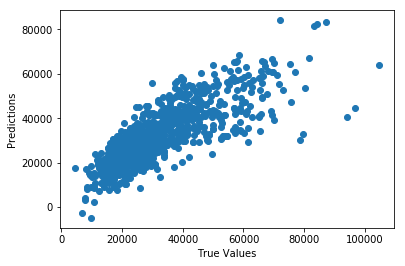

In [132]:
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

### Cross-validation

In [ ]:

X = np.array([[1, 2], [3, 4]])
y = np.array([1, 2])
loo = LeaveOneOut()
loo.get_n_splits(X)


for train_index, test_index in loo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(X_train, X_test, y_train, y_test)

In [ ]:

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]]) # create an array
y = np.array([1, 2, 3, 4]) # Create another array
kf = KFold(n_splits=2) # Define the split - into 2 folds 
kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
print(kf) 
KFold(n_splits=2, random_state=None, shuffle=False)

In [ ]:
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]